In [ ]:
#Install the proper libraries needed
!pip install py2neo==2.0
!pip install jgraph

In [1]:
from PIL import Image
import webbrowser
import datetime
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import json
from pprint import pprint
import boto3
import jgraph
from py2neo import Graph, authenticate, Relationship
import urllib.request
from scripts.rekgraph import rekrelationships
%matplotlib inline

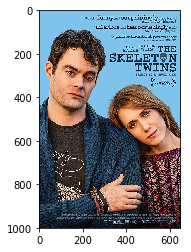

In [19]:
#retrieve and print a selected image
imshow(np.asarray(Image.open('wiig.jpg', 'r')))

data type and length of the response from the detect_faces call
<class 'dict'>
3
the number of faces detected in the picture
2
printing face bounding boxes below

face number 0
0.04930662736296654
0.1770000010728836
0.4360554814338684
0.28299999237060547

face number 1
0.5993836522102356
0.41200000047683716
0.2927580773830414
0.1899999976158142
width 649
height 1000


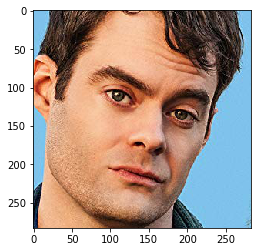

In [20]:
#detect faces in the first picture in the image
client = boto3.client('rekognition', region_name='us-east-1')
response = client.detect_faces(
    Image={
        'Bytes': open('wiig.jpg','rb').read().strip()
    }
)
#the api returns a json dictionary of length 3
print('data type and length of the response from the detect_faces call')
print(type(response))
print(len(response))
 
#parsing out that dictionary
#print (response['ResponseMetadata'])
#print()
#print (response['FaceDetails'])
#print()
#print (response['OrientationCorrection'])
 
#print how many faces are in this picture
print('the number of faces detected in the picture')
faceCount=len(response['FaceDetails'])
print(faceCount)
 
if(faceCount>0):
    #next step is to show only the cropped faces
    #the IndexFaces api call will automatically take care of this parsing
    #for you when sending pictures with multiple faces to a FaceCollection.
    print('printing face bounding boxes below')
    counter=0
    #which of the faces from the photo do you want to print? rekognition makes the
    #largest face equal to index zero
    faceNumToKeep=0
    #these toKeep____ variables are to give flexibility
    #on which face to crop and print
    toKeepLeft=0.0
    toKeepTop=0.0
    toKeepWidth=0.0
    toKeepHeight=0.0
 
    #if you care to see the raw data that we parse in the for loop below
    #boundingBox=response['FaceDetails'][0]['BoundingBox']
    #print(boundingBox)
 
    #loop over each face and print the bounding boxes, save the one
    #specified by the faceNumToKeep param
    #for pictures with multiple faces, Rekognition starts with the largest face and moves iteratively to smaller ones
    for x in response['FaceDetails']:
        print('\nface number '+str(counter))
        boundingBox=x['BoundingBox']
        #print(boundingBox)
        print(boundingBox['Left'])
        print(boundingBox['Top'])
        print(boundingBox['Width'])
        print(boundingBox['Height'])
        if (counter==faceNumToKeep):
            toKeepLeft=boundingBox['Left']
            toKeepTop=boundingBox['Top']
            toKeepWidth=boundingBox['Width']
            toKeepHeight=boundingBox['Height']
        counter=counter+1
   
    #retrieve the whole photo, crop the face of interest and print                                                                 
    pil_im = Image.open('wiig.jpg', 'r')
   
    picwidth=pil_im.size[0]
    picheight=pil_im.size[1]
    print('width '+str(picwidth))
    print('height '+str(picheight))
    imshow(np.asarray(pil_im.crop((
        picwidth*toKeepLeft,
        picheight*toKeepTop,
        picwidth*toKeepLeft+picwidth*toKeepWidth,
        picheight*toKeepTop+picheight*toKeepHeight
                             ))))
 

In [22]:
#detect celebrities
response = client.recognize_celebrities(
    Image={
        'Bytes': open('wiig.jpg','rb').read().strip()
    }
)

print ('num celebrities found: '+str(len(response['CelebrityFaces'])))
for i in response['CelebrityFaces']:
    print(i['Name'])
    imageName = i['Name']
    
name1=response['CelebrityFaces'][0]['Name']

num celebrities found: 2
Bill Hader
Kristen Wiig


In [23]:
authenticate("localhost:7474", "neo4j", "password")
graph = Graph()
graph.neo4j_version

(3, 1, 7)

In [24]:
query="""
MATCH p=shortestPath(
  (p1:Person {name:"Kevin Bacon"})-[*]-(p2:Person {name:"Bill Hader"})
)
UNWIND nodes(p) as n
RETURN n.name, n.title
"""
result=graph.cypher.execute(query)
result

   | n.name       | n.title                                       
---+--------------+------------------------------------------------
 1 | Kevin Bacon  |                                               
 2 |              | The Air I Breathe                             
 3 | Jon Bernthal |                                               
 4 |              | Night at the Museum: Battle of the Smithsonian
 5 | Bill Hader   |                                               

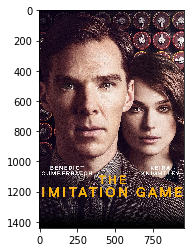

In [25]:
#now we bring it all together: bring in a second photo, and retrieve how the two actors/actresses know each other
imshow(np.asarray(Image.open('imitation.jpg', 'r')))

In [28]:
response = client.recognize_celebrities(
    Image={
        'Bytes': open('imitation.jpg','rb').read().strip()
    }
)

print ('num celebrities found: '+str(len(response['CelebrityFaces'])))
for i in response['CelebrityFaces']:
    print (i['Name'])
    imageName = i['Name']
name2=response['CelebrityFaces'][0]['Name']

num celebrities found: 2
Benedict Cumberbatch
Keira Knightley


In [29]:
"""
Copyright 2017 Amazon.com, Inc. or its affiliates. All Rights Reserved.

Licensed under the Amazon Software License (the "License"). You may not use this file except in compliance with the License. 
A copy of the License is located at

    http://aws.amazon.com/asl/

or in the "license" file accompanying this file. This file is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, 
express or implied. See the License for the specific language governing permissions and limitations under the License.
"""


from IPython.display import IFrame
import json
import uuid
from py2neo import cypher



def graphbacon(noded,linkd):	
    html = """
		<html>
		<head>


		<style>
		.links line {{
		stroke: #aaa;
		}}

		.nodes circle {{
		pointer-events: all;
		stroke: none;
		stroke-width: 40px;
		}}

		</style>
		</head>
		<body>
		<svg width="600" height="400"></svg>
		<div id=\"{id}\"></div>
		<script type="text/javascript" src="d3.min.js"></script>

		<script type="text/javascript">
		var loc = 20;
		var svg = d3.select("svg"),
		width = +svg.attr("width"),
		height = +svg.attr("height");

		var simulation = d3.forceSimulation()
		.force("link", d3.forceLink().id(function(d) {{ return d.id; }}))
		.force("charge", d3.forceManyBody())
		.force("center", d3.forceCenter(width /2 , height / 2));


		var nodes = {nodedata};
		var links = {linkdata};



		var link = svg.append("g")
		.attr("class", "links")
		.selectAll("line")
		.data(links)
		.enter().append("line");

		var node = svg.append("g")
		.attr("class", "nodes");

		var circles = node
		.selectAll("circle")
		.data(nodes)
		.enter().append("circle")
		.attr("r", 20)
		.attr("fill", function (d){{
		if (d.label == 'Movie')
		return "Aqua"
		else 
		return "Grey"
		}})
		.call(d3.drag()
		.on("start", dragstarted)
		.on("drag", dragged)
		.on("end", dragended));


		var text = node
		.selectAll("text")
		.data(nodes)
		.enter().append("text")
		.attr("text-anchor","middle")
		.text(function(d){{
		return d.title
		}});




		simulation
		.nodes(nodes)
		.on("tick", ticked);

		simulation.force("link")
		.links(links);

		function ticked() {{
		link
		.attr("x1", function(d) {{ return d.source.x; }})
		.attr("y1", function(d) {{ return d.source.y; }})
		.attr("x2", function(d) {{ return d.target.x; }})
		.attr("y2", function(d) {{ return d.target.y; }});


		circles
		.attr("cx", function(d) {{ return d.x; }})
		.attr("cy", function(d) {{ return d.y; }})
		// .selectAll("text")
		// .attr("x", function(d) {{return d.x}})
		// .attr("y", function(d) {{return d.y}});

		text
		.attr("x", function(d) {{return d.x}})
		.attr("y", function(d) {{return d.y}})

		}};

		function dragstarted(d) {{
		if (!d3.event.active) simulation.alphaTarget(0.01).restart();
		d.fx = d.x;
		d.fy = d.y;
		}}

		function dragged(d) {{
		d.fx = d3.event.x;
		d.fy = d3.event.y;
		}}

		function dragended(d) {{
		if (!d3.event.active) simulation.alphaTarget(0);
		d.fx = null;
		d.fy = null;
		}}

		function idIndex(a,id) {{
		for (var i=0;i<a.length;i++) {{
		if (a[i].id == id) return id;
		}}
		return null;
		}}

		</script>
		</body>
		</html>
	"""
    
    unique_id = str(uuid.uuid4())

    html = html.format(id=unique_id,nodedata=json.dumps(noded, indent=1),linkdata=json.dumps(linkd, indent=1))
    filename = "relationships-{}.html".format(unique_id)
    file = open(filename, "w")
    file.write(html)
    file.close()
    return IFrame(filename, width="600%", height="400")

def rekrelationships2(graph, actor1, actor2):
	query = """
	MATCH p=shortestPath((bacon:Person {{name:\"{actor1}\"}})-[*]-(meg:Person {{name:\"{actor2}\"}}) ) RETURN p
	"""
	query = query.format(actor1=actor1,actor2=actor2)
	#result = graph.run(query)
	result = graph.cypher.execute(query)
	subg = result.to_subgraph()
	relRes= subg.relationships
	nodesRes = subg.nodes

	nodes = []
	links = []

	for node in nodesRes:
		labelList = node.labels
		label = l = labelList.pop()
		if l =='Movie' :
			title = node.properties.get("title","")
		else:
			title = node.properties.get("name","")
		id = node.properties.get("id","")
		nodes.append({"title":title,"label":label,"id":id})

		for rel in relRes:
			links.append({"source":rel.start_node.properties.get("id",""),"target":rel.end_node.properties.get("id",""),"type":rel.type})

	return graphbacon(nodes,links)

In [30]:
print("Querying Neo4j for connection between %s and %s!" % (name1, name2))
query="""
MATCH p=shortestPath(
  (p1:Person {name:"%s"})-[*]-(p2:Person {name:"%s"})
)
UNWIND nodes(p) as n
RETURN n.name, n.title
"""%(name1, name2)
print(query)
result=graph.cypher.execute(query)
print(result)
rekrelationships2(graph,name1,name2)

Querying Neo4j for connection between Bill Hader and Benedict Cumberbatch!

MATCH p=shortestPath(
  (p1:Person {name:"Bill Hader"})-[*]-(p2:Person {name:"Benedict Cumberbatch"})
)
UNWIND nodes(p) as n
RETURN n.name, n.title

   | n.name               | n.title                                       
---+----------------------+------------------------------------------------
 1 | Bill Hader           |                                               
 2 |                      | Night at the Museum: Battle of the Smithsonian
 3 | Steve Coogan         |                                               
 4 |                      | The Revengers Comedies                        
 5 | Kristin Scott Thomas |                                               
 6 |                      | The Other Boleyn Girl                         
 7 | Benedict Cumberbatch |                                               

